In [85]:
import openmc.deplete as dpl
import openmc.data as data
import openmc
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d as interp1d
import scipy.interpolate as interp
Bq2Ci = 1 / 3.7e10

import matplotlib as mpl
params = {'image.aspect':'equal',
          'savefig.dpi':600,
          'axes.grid':True,
          'font.size':12,
          'text.color':'black',
          'image.cmap':'viridis'}

mpl.rcParams.update(params)

In [2]:
results = dpl.results.Results('20kp_50i_150b/depletion_results.h5')
activity_results = dpl.results.Results('activity_redone/depletion_results.h5')
time_step = results.get_step_where(20,'a')
materials = results.export_to_materials(time_step,path = '20kp_50i_150b/materials.xml')

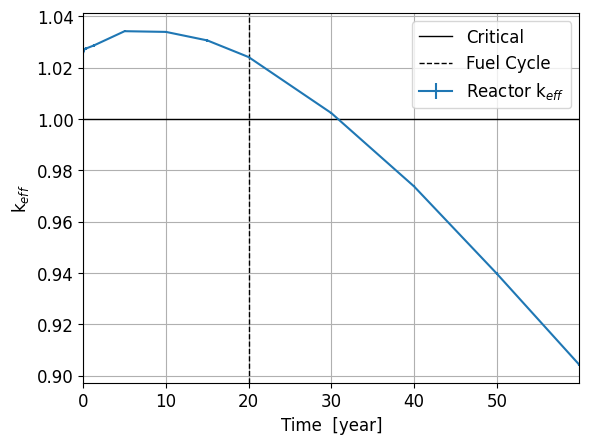

In [3]:
t, k_ = results.get_keff('a')
k_eff, err = list(zip(*k_))
plt.errorbar(t, k_eff, err, label='Reactor k$_{eff}$')
plt.ylabel('k$_{eff}$')
plt.xlabel('Time  [year]')
plt.xlim(t[0],t[-1])
plt.axhline(1.0, color = 'k', linewidth = 1, label = 'Critical')
plt.axvline(20, color = 'k', linewidth = 1, linestyle='--', label = 'Fuel Cycle')
plt.legend()
#plt.savefig('60y-keff.png', dpi=600)

In [4]:
mat_mass = [0]*3
nuc_mass = {}


for mat in materials[:3]:
    for nuc, per, _ in mat.nuclides:
        time, mass = results.get_mass(str(mat.id), nuc, mass_units='kg', time_units='a')
        mat_mass[mat.id-1] += mass[time_step]

        try:
            nuc_mass[nuc] += mass[time_step]

        except:
            nuc_mass[nuc] = mass[time_step]

total_mass = sum(mat_mass)
material = openmc.Material()
for nuc, mass in nuc_mass.items():
    material.add_nuclide(nuc, mass / total_mass, 'wo')
    
material.volume = 1.0
material.set_density('g/cm3', total_mass*1e3)

SNF_MATERIAL = openmc.Materials([material])
SNF_MATERIAL.export_to_xml('spent_single_fuel.xml')

In [102]:
snf_activity = np.zeros(33)
for mat in ['1', '2', '3']:
    act_times, activity = activity_results.get_activity(mat, 'Bq')
    snf_activity += activity * Bq2Ci * 1e-6
SNF_ACTIVITY_MCi = interp1d(act_times / 3600 / 24 / 365, snf_activity)

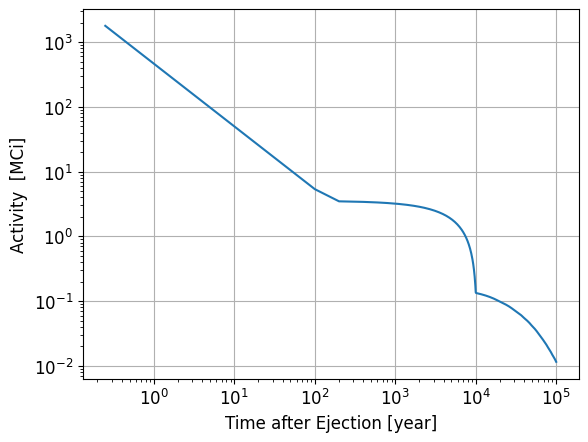

In [103]:
times = np.linspace(.25,100000+20, 1000)
plt.loglog(times, SNF_ACTIVITY_MCi(times))
plt.xlabel('Time after Ejection [year]')
plt.ylabel('Activity  [MCi]')
plt.savefig('Activity', dpi=600)

# Evaluation Criteria

## Nuclear Waste Management Criterion 

In [101]:
SNF_MASS = (total_mass /1e3)
GWh_e = .1 # 100 MWe
GWe_YEAR = GWh_e * 20
MASS_SNF_PER_ENERGY = SNF_MASS / GWe_YEAR
## Activity is done in activty_at_ depletion...

MCi_GWeYEAR_100 = SNF_ACTIVITY_MCi(100) / GWe_YEAR
MCi_GWeYEAR_100000 = SNF_ACTIVITY_MCi(100000) / GWe_YEAR

pu_mass = {}
u_mass = {}
for i in range(2, 246):
    k = 'Pu' + str(i)
    if k in nuc_mass.keys():
        pu_mass[k] = nuc_mass[k]

    k = 'U' + str(i)
    if k in nuc_mass.keys():
        u_mass[k] = nuc_mass[k]

DU_RU_RTh = sum(u_mass.values()) / 1e3
DU_RU_RTh_PER_ENERGY = DU_RU_RTh / GWe_YEAR

#TABLE C-1.12
LLW_PROCESS = 56
GTCC_PROCESS = 2.6
LLW_DD = 205
GTCC_DD = 15

LLW_PRODUCTION = np.array([LLW_PROCESS, LLW_DD]) * GWe_YEAR #m3... this has to be wrong
GTCC_PRODUCTION = np.array([GTCC_PROCESS, GTCC_DD]) * GWe_YEAR
sum(LLW_PRODUCTION), sum(GTCC_PRODUCTION)

np.float64(4.215362037994577)

## Proliferation

In [116]:
# SQ from page 35  https://www.iaea.org/sites/default/files/iaea_safeguards_glossary.pdf

#Plutonium is a direct use material, if less than 20% Pu238
MASS_PU = sum(pu_mass.values())
ENRICHMENT_PU239 = pu_mass['Pu239'] / MASS_PU
ENRICHMENT_PU238 = pu_mass['Pu238'] / MASS_PU
SQ_PU = 8.0
NUM_SQ_PU = MASS_PU / SQ_PU


#Uranium is a direct use material

MASS_U = sum(u_mass.values())
ENRICHMENT_U235 = u_mass['U235'] / MASS_U
SQ_U = 75 #kg U235 in <20% enriched uranium
NUM_SQ_U = u_mass['U235'] / SQ_U

MASS_PU, MASS_PU*ENRICHMENT_PU239

(np.float64(1120.8066738809455), np.float64(1059.0902311095074))

## Nuclear Material Security Risk Criterion

In [114]:
#activity at 10 years of SNF
MCi_GWeYEAR_10 = SNF_ACTIVITY(30) / 1e6 / GWe_YEAR
MCi_GWeYEAR_10

np.float64(901.9636681996875)

## Safety Criterion

In [8]:
# for eg2 -> likely safer that current, but hard to say, much less waste so safer, but higher enrichment...

# for repro -> Much harder to say, given additional safety concerns from reprocessing

## Environmental Impact Criterion

In [9]:
# Table C-5.2 for land-use factors. This is done in Cyclus postprocessing

# Table C-5.7 for water-use factors. This is done in Cyclus postprocessing

# Table C-5.15 for CO2. This is done in Cyclus postprocessing

# Table C-5.41 for Factors, C-5.28 for worker dose from reactor for SFR.

# Resource Utilization Criterion

In [115]:
# Tons of Natural Uranium used per GWe-year
TONS_NAT_U_20YEARS = 7.511561e+02
TONS_NAT_U_PER_ENERGY = TONS_NAT_U_20YEARS / (GWe_YEAR * 20)
TONS_NAT_U_PER_ENERGY

18.7789025

# Development and Deployment Risk Criterion

In [11]:
# Table C-7.1 for definitions
#Likely TRL9, or TRL8 --- they identify as Bin D and C for deployment and development, respectively
# Estimate 2-10 Billion dollars until First-Of-A-Kind

#Kind of Compatible with current fuel cycle --- more than 50% of current can be used but less than 90%

# Licensing --- Authors say fast reactors have little licensing experience (Only ones are DOE projects)

# Capital at risk - pages 118 - 124

# Institutional Issues Criterion

In [12]:
#Read

# Financial Risk and Economics Criterion

In [13]:
# yeah i mean they give a bunch of formulas

In [ ]:
Nuclear Waste Management, Proliferation, Nuclear Material Security Risk, Safety, Environmental Impact, Resource Utilization, Development and Deployment Risk, Institutional Issues, and Financial Risk and Economics

In [66]:
import lxml.etree as etree
def recipify(mat, _name):
        subdict = {}
        for name,per in mat.items():
            z, a, _ = data.zam(name)
            zaid = z*1000 + a
            subdict[zaid] = per
    
        recipe = etree.Element('recipe')
        
        name = etree.Element('name')
        name.text = _name
        recipe.append(name)
        
        basis = etree.Element('basis')
        basis.text = 'mass'
        recipe.append(basis)
    
        for zaid, per in subdict.items():
            nuclide = etree.Element('nuclide')
            
            _id = etree.Element('id')
            zaid = str(zaid)
            _id.text = '0'*(5-len(zaid)) + zaid
            nuclide.append(_id)
            
            comp = etree.Element('comp')
            comp.text = str(per)
            nuclide.append(comp)
    
            recipe.append(nuclide)

        
        return recipe

def recipes(recipess):
    root = etree.Element('recipes')
    for recipe in recipess:
        root.append(recipe)
    recipes = etree.ElementTree(root)
    recipes.write(f'processed.xml', pretty_print=True)
    return

In [67]:
u, pu = recipify(u_mass, 'processed_u'), recipify(pu_mass, 'processed_pu')

In [68]:
recipes([u, pu])